# Demo Prophet Time Series Forecasting on Ray local

<b>Suggestion: Make a copy of this notebook.  This way you will retain the original, executed notebook outputs.  Make edits in the copied notebook. </b>

### Description:  
Demo using Time Series Forecasting Prophet algorithm on Ray.  Example data is NYC yellow taxi from: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page  <br>

Forecast goal:  Given 6 months historical taxi trips data for NYC, your task is to predict #pickups at each location in NYC at monthly level for the next 2 months.

### Demo notes:
Output shows timings using MEDIUM dataset <br>
Both demo datasets are available in this github repo under data/  <br>
SMALL dataset contains original, actual 260 items "clean_taxi_monthly.parquet" <br>
MEDIUM dataset contains 2860 items with extra fakes "clean_taxi_monthly_fake_medium.parquet" <br>

In [ ]:
# install open-source Ray if you haven't already
# !pip install "ray[default] installs the latest version; otherwise use a specific version
# !pip install "ray[default]==1.8.0"

# install ARIMA library
# !pip install pmdarima

# install Prophet library
# !pip install kats

# install Anyscale to run Ray easily on a Cloud
# !pip install anyscale

In [1]:
###########
# Import libraries
###########

# Open-source libraries
import os  # Python os functions
import logging #Python logging functions
import time  # Python time functions
import warnings  # Python warnings
warnings.filterwarnings('ignore')
import ray   # Run distributed code
import numpy as np  # Numerical processing
import pandas as pd  # Dataframe (tabular data) processing
import matplotlib as mpl  # Graph plotting
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

# Open-source ARIMA forecasting libraries
import pmdarima as pm
from pmdarima.model_selection import train_test_split

# Open-source Prophet forecasting libraries
# Note: using kats since it looks more actively maintained than original prophet
import kats
from kats.consts import TimeSeriesData
from kats.models.prophet import ProphetModel, ProphetParams

!python --version
print(f"ray: {ray.__version__}")
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"matplotlib: {mpl.__version__}")
AVAILABLE_LOCAL_CPU = os.cpu_count()
print(f"Found available CPU: {AVAILABLE_LOCAL_CPU}")

Python 3.8.12
ray: 1.8.0
numpy: 1.20.3
pandas: 1.3.4
matplotlib: 3.5.0
Found available CPU: 8


# Change how you want to run Ray below.  
<b>Depending on whether you want to run Ray Local or Ray in a Cloud:</b>
<ul>
    <li><b>To run Ray Local, change below variables, then continue running cells in the notebook</b>: <br>
        RUN_RAY_LOCAL = True; RUN_RAY_ON_A_CLOUD = False</li>
    <li><b>To run Ray in a Cloud, change below variables, then continue running cells in the notebook</b>: <br>
        RUN_RAY_LOCAL = False; RUN_RAY_ON_A_CLOUD = True </li>
    </ul>


In [11]:
###########
# CHANGE VARIABLES BELOW.
# To run Ray Local: RUN_RAY_LOCAL = True; RUN_RAY_ON_A_CLOUD = False
# To run Ray in a Cloud: RUN_RAY_LOCAL = False; RUN_RAY_ON_A_CLOUD = True
###########

RUN_RAY_LOCAL = True
RUN_RAY_ON_A_CLOUD = False

In [12]:
###########
# Run Ray Local on your laptop for testing purposes
# Dashboard doc: https://docs.ray.io/en/master/ray-dashboard.html#ray-dashboard
###########

if RUN_RAY_LOCAL:
    print("You are running Ray Local")

    # NUM_CPU is optional.  By default Ray will automatically detect and use all available.
    NUM_CPU = AVAILABLE_LOCAL_CPU

    ray.shutdown()   #in case a different ray server is already running
    ray.init(
        # prevent errors in case re-running notebook
        ignore_reinit_error=True,
        num_cpus=NUM_CPU,
    )

else:
    print("You are not running Ray Local")


You are running Ray Local


2021-11-28 20:13:35,693	INFO services.py:1270 -- View the Ray dashboard at http://127.0.0.1:8269


In [13]:
###########
# Run Ray in the Cloud using Anyscale
# View your cluster on console.anyscale.com
###########

if RUN_RAY_ON_A_CLOUD:
    print("You are running Ray on a Cloud")
    
    # !pip install anyscale  # install anyscale if you haven't already
    import anyscale

    # You can specify more pip installs, clone github, or copy code/data here in the runtime env.
    # Everything in the runtime environment will override the cluster environment.
    # https://docs.anyscale.com/user-guide/configure/dependency-management/cluster-and-runtime-environments
    my_env={ "working_dir": ".",
            "pip": ["pmdarima", "kats"],
           }

    ray.shutdown()   #in case a different ray server is already running
    ray.init(
        "anyscale://christy-forecast5",
        # runtime_env=my_env,
        # optionally put pip installs in the cluster config instead of runtime_env
        cluster_env="christy-forecast:4",

        # Add extra quiet settings, since Prophet is noisy!
        log_to_driver=False,  # disable ray workers from logging the output.
        configure_logging=True,
        logging_level=logging.ERROR,
    )
    
else:
    print("You are not running Ray on a Cloud")


You are not running Ray on a Cloud


# Read 8 months clean NYC taxi data 

New York City Yellow Taxi ride volumes per location (8 months of historical data). <ul>
    <li>Original source: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page</li>
    <li>Clean monthly source:  https://github.com/christy/AnyscaleDemos/blob/main/forecasting_demos/data/clean_taxi_monthly_fake_medium.parquet?raw=true </li>
    </ul>

Normally there is a data cleaning/prep step to convert raw data -> cleaned data.  We'll dig into details of ETL later.  <br>
For now, let's just start with cleaned, aggregated monthly data for ARIMA and Prophet, since those algorithms are typically for strategic-level forecasting, not typically for detailed-level forecasting.

In [5]:
###########
# Read pandas dataframe
# If you cloned this notebook from github the data should be in your data/ folder
###########
# read 8 months of clean, aggregated monthly taxi data
# filename = "https://github.com/christy/AnyscaleDemos/blob/main/forecasting_demos/data/clean_taxi_monthly_fake_medium.parquet?raw=true"
# filename = "data/clean_taxi_monthly.parquet"
filename = "data/clean_taxi_monthly_fake_medium.parquet"
g_month = pd.read_parquet(filename)

# rename "time" column, since prophet expects that, arima doesn't care
g_month.reset_index(inplace=True)
g_month.rename(columns={"pickup_monthly": "time"}, inplace=True)

display(g_month.head())

# Train a model per item_id
item_list = list(g_month["pulocationid"].unique())
print(f"Number unique items = {len(item_list)}")


,index,time,pulocationid,trip_quantity
0,0,2019-07-31,1,50
1,1,2019-07-31,10,2201
2,2,2019-07-31,100,138614
3,3,2019-07-31,101,63
4,4,2019-07-31,102,97


Number unique items = 2860


# Regular Python

In [6]:
###########
# Assume below is already-existing regular Python code.
###########

# define file handler, not appending, to avoid growing logs
file_handler = logging.FileHandler('training.log', mode='w')
formatter    = logging.Formatter('%(asctime)s : %(levelname)s : %(name)s : %(message)s')
file_handler.setFormatter(formatter)

# prophet logger - also need Class below to stop the noisy PyStan messages
prophet_logger = logging.getLogger('fbprophet')
prophet_logger.setLevel(logging.ERROR)
prophet_logger.addHandler(file_handler)


# This class is to suppress the Pystan noisy messages coming from Prophet
# Thanks to https://github.com/facebook/prophet/issues/223#issuecomment-326455744
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        for fd in self.null_fds + self.save_fds:
            os.close(fd)


###########
# Prophet train_model function, default train on 6 months, inference 2
###########
def train_model_PROPHET(
    theDF: pd.DataFrame,
    item_col: str,
    item_value: str,
    target_col: str,
    train_size: int = 6,
) -> list:
    """This function trains a model using Prophet algorithm. 

    Args:
        theDF (pd.DataFrame): Input data.  It must have a "time" column.
                theDF should not be indexed by "time".
        item_col (str): Name of the column containing item_id or SKU.
        item_value (str): Value of the item_id or SKU being forecasted.
        target_col (str): Name of the column containing the actual value.
        train_size (int, optional): Count of number of timestamps to use 
                for training. Defaults to 6.

    Returns:
        list: [
            train (pd.DataFrame):  Training data.
            test (pd.DataFrame):  Test data for evaluation.
            model (pmdarima.arima.arima.ARIMA): ARIMA model for inference.
        ]
    """

    # Set seed for reproducibility, use same seed in train AND inference
    np.random.seed(415)

    # split data into train/test
    train, test = train_test_split(
        theDF.loc[(theDF[item_col] == item_value), :], train_size=train_size
    )

    # convert pandas df to TimeSeriesData(df), with "time" column and any number of value columns.
    train_ts = TimeSeriesData(train[["time", target_col]])
    test_ts = TimeSeriesData(test[["time", target_col]])

    # create a prophet model param instance
    params = ProphetParams(
        seasonality_mode="multiplicative"
    )

    # create a prophet model instance
    model = ProphetModel(train_ts, params)
    
    # fit model
    with suppress_stdout_stderr():  #suppress pystan messages
        model.fit()

    # index train, test by time
    train.set_index("time", inplace=True)
    test.set_index("time", inplace=True)
    return [train, test, model]


###########
# Prophet inference_model function
###########
def inference_model_PROPHET(
    model: "kats.models.prophet.ProphetModel",
    test: pd.DataFrame,
    item_col: str,
    target_col: str,
) -> pd.DataFrame:
    """This function inferences a model using Prophet algorithm.  It uses
                  the actual values, if known, in the test evaluation dataframe 
                  and concats them into the forecast output dataframe, 
                  for easier evaluation later.

    Args:
        model (kats.models.prophet.ProphetModel): Prophet model.
        test (pd.DataFrame): Test data for evaluation.
        item_col (str): Name of the column containing item_id or SKU.
        target_col (str): Name of the column containing the actual value.

    Returns:
        pd.DataFrame: forecast as pandas dataframe containing the forecast along  
                       with actual values.
    """

    # Set seed for reproducibility, use same seed in train AND inference
    np.random.seed(415)

    # Prophet inference on test data
    forecast = model.predict(steps=test.shape[0], freq="MS")

    # put both actual_value and predicted_value in forecast, for easier eval later
    forecast.fcst = forecast.fcst.astype(np.int32)
    forecast.fcst_lower = forecast.fcst_lower.astype(np.int32)
    forecast.fcst_upper = forecast.fcst_upper.astype(np.int32)
    forecast.columns = [
        "time",
        "fcst_prophet",
        "fcst_prophet_lower",
        "fcst_prophet_upper",
    ]
    forecast = pd.concat(
        [forecast, test.loc[:, target_col].reset_index(drop=True)], axis=1
    )
    forecast.set_index("time", inplace=True)

    return forecast


In [17]:
###########
# REGULAR PYTHON program flow to train and inference Prophet models
###########

# initialize objects
train = []
test = []
model = []
forecast = []

start = time.time()

# Train every model
train, test, model = map(
    list,
    zip(
        *(
            [
                train_model_PROPHET(
                    g_month.copy(),
                    item_col="pulocationid",
                    item_value=v,
                    target_col="trip_quantity",
                    train_size=6,
                )
                for p, v in enumerate(item_list)
            ]
        )
    ),
)

# Inference every model
forecast = [
    inference_model_PROPHET(
        model[p],
        test[p],
        item_col="pulocationid",
        target_col="trip_quantity",
    )
    for p in range(len(item_list))
]


time_regular_python = time.time() - start
print(
    f"Done! Prophet on Regular Python finished in {time_regular_python} seconds"
)

Done! Prophet on Regular Python finished in 2222.609594106674 seconds


len(forecast): 2860


,fcst_prophet,fcst_prophet_lower,fcst_prophet_upper,trip_quantity
time,,,,
2020-01-01,49,44,54,34
2020-02-01,49,43,54,35


,fcst_prophet,fcst_prophet_lower,fcst_prophet_upper,trip_quantity
time,,,,
2020-01-01,1859,1736,1979,1689
2020-02-01,1801,1669,1933,1386


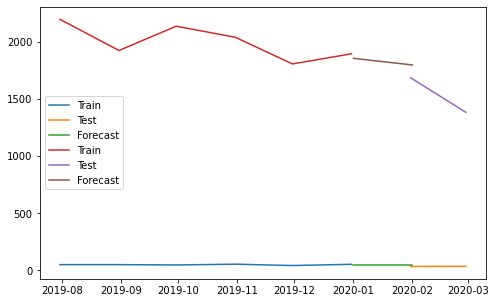

In [18]:
###########
# inspect a few forecasts
###########

assert len(model) == len(item_list)
assert len(forecast) == len(item_list)
print(f"len(forecast): {len(forecast)}")

# plot first two forecasts
plt.figure(figsize=(8, 5))
for p, v in enumerate(item_list[0:2]):
    display(forecast[p])
    plt.plot(train[p]["trip_quantity"], label="Train")
    plt.plot(test[p]["trip_quantity"], label="Test")
    plt.plot(forecast[p]["fcst_prophet"], label="Forecast")
    plt.legend(loc="best")


# Ray distributed Python

In [ ]:
#%%timeit
###########
# Main Ray distributed program flow to train and inference Prophet models
###########

# Convert your previously-defined regular python functions to ray parallelized functions
train_model_PROPHET_remote = ray.remote(train_model_PROPHET).options(num_returns=3)
inference_model_PROPHET_remote = ray.remote(inference_model_PROPHET)

# initialize objects
train_obj_refs = []
test_obj_refs = []
model_obj_refs = []
forecast_obj_refs = []

# This step required for Ray 1.8 and below
# initialize data in ray object store on each cluster
input_data_ref = ray.put(g_month.copy())

start = time.time()

# Train every model
train_obj_refs, test_obj_refs, model_obj_refs = map(
    list,
    zip(
        *(
            [
                train_model_PROPHET_remote.remote(
                    # g_month, 
                    input_data_ref,
                    item_col="pulocationid",
                    item_value=v,
                    target_col="trip_quantity",
                    train_size=6,
                )
                for p, v in enumerate(item_list)
            ]
        )
    ),
)

# Inference every model
forecast_obj_refs = [
    inference_model_PROPHET_remote.remote(
        model_obj_refs[p],
        test_obj_refs[p],
        item_col="pulocationid",
        target_col="trip_quantity",
    )
    for p in range(len(item_list))
]


# ray.get() means block until all objectIDs requested are available
forecast_ray = ray.get(forecast_obj_refs)

time_ray_local = time.time() - start
print(
    f"Done! Prophet on Ray Local finished in {time_ray_local} seconds"
)

# Verify forecasts

In [16]:
# Run the Ray local code again to get the forecasts
###########
# Main Ray distributed program flow to train and inference Prophet models
###########

# Convert your previously-defined regular python functions to ray parallelized functions
train_model_PROPHET_remote = ray.remote(train_model_PROPHET).options(num_returns=3)
inference_model_PROPHET_remote = ray.remote(inference_model_PROPHET)

# initialize objects
train_obj_refs = []
test_obj_refs = []
model_obj_refs = []
forecast_obj_refs = []

# This step required for Ray 1.8 and below
# initialize data in ray object store on each cluster
input_data_ref = ray.put(g_month.copy())

start = time.time()

# Train every model
train_obj_refs, test_obj_refs, model_obj_refs = map(
    list,
    zip(
        *(
            [
                train_model_PROPHET_remote.remote(
                    # g_month, 
                    input_data_ref,
                    item_col="pulocationid",
                    item_value=v,
                    target_col="trip_quantity",
                    train_size=6,
                )
                for p, v in enumerate(item_list)
            ]
        )
    ),
)

# Inference every model
forecast_obj_refs = [
    inference_model_PROPHET_remote.remote(
        model_obj_refs[p],
        test_obj_refs[p],
        item_col="pulocationid",
        target_col="trip_quantity",
    )
    for p in range(len(item_list))
]


# ray.get() means block until all objectIDs requested are available
forecast_ray = ray.get(forecast_obj_refs)

time_ray_local = time.time() - start
print(
    f"Done! Prophet on Ray Local finished in {time_ray_local} seconds"
)

(train_model_PROPHET pid=13364) 
(train_model_PROPHET pid=13363) 
(inference_model_PROPHET pid=13367) 
Done! Prophet on Ray Local finished in 458.65933322906494 seconds


In [19]:
# Calculate speedup:
speedup = time_regular_python / time_ray_local
print(f"Speedup from running Ray parallel code on your laptop: {np.round(speedup, 1)}x"
      f", or {(np.round(speedup, 0)-1) * 100}%")


Speedup from running Ray parallel code on your laptop: 4.8x, or 400.0%


In [20]:
# Verify ray forecast is same as regular Python forecast

assert len(forecast_ray) == len(forecast)
assert len(forecast_ray[0]) == len(forecast[0])
assert forecast_ray[0].equals(forecast[0])


len(forecast): 2860


,fcst_prophet,fcst_prophet_lower,fcst_prophet_upper,trip_quantity
time,,,,
2020-01-01,49,44,54,34
2020-02-01,49,43,54,35


,fcst_prophet,fcst_prophet_lower,fcst_prophet_upper,trip_quantity
time,,,,
2020-01-01,1859,1736,1979,1689
2020-02-01,1801,1669,1933,1386


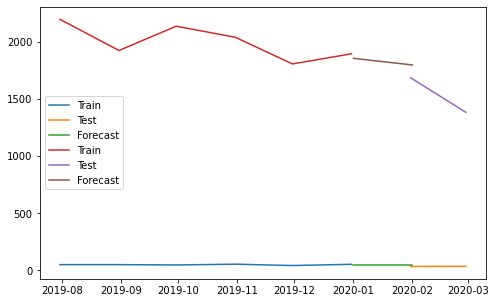

In [21]:
###########
# inspect a few forecasts
###########

assert len(model) == len(item_list)
assert len(forecast) == len(item_list)
print(f"len(forecast): {len(forecast_ray)}")

# plot first two forecasts
train = ray.get(train_obj_refs)
test = ray.get(test_obj_refs)
plt.figure(figsize=(8, 5))
for p in range(len(item_list[0:2])):
    display(forecast_ray[p])
    plt.plot(train[p]["trip_quantity"], label="Train")
    plt.plot(test[p]["trip_quantity"], label="Test")
    plt.plot(forecast_ray[p]["fcst_prophet"], label="Forecast")
    plt.legend(loc="best")


Forecast for item 1:


,fcst_prophet,fcst_prophet_lower,fcst_prophet_upper,trip_quantity
time,,,,
2020-01-01,49,44,54,34
2020-02-01,49,43,54,35


Forecast for item 10:


,fcst_prophet,fcst_prophet_lower,fcst_prophet_upper,trip_quantity
time,,,,
2020-01-01,1859,1736,1979,1689
2020-02-01,1801,1669,1933,1386


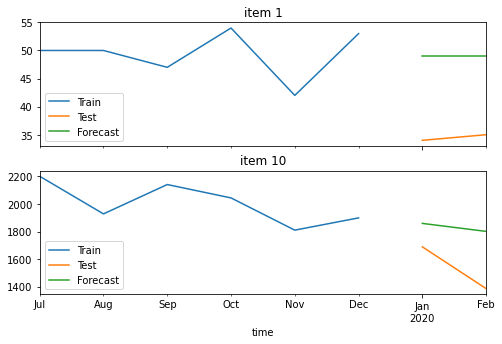

In [22]:
# fancier plots
# plot first two forecasts
fig, axs = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
for p, v in enumerate(item_list[0:2]):
    print(f"Forecast for item {v}:")
    display(forecast_ray[p])

    ax = axs[p]
    train[p].trip_quantity.plot(ax=ax, label="Train")
    test[p].trip_quantity.plot(ax=ax, label="Test")
    forecast_ray[p].fcst_prophet.plot(ax=ax, label="Forecast")
    ax.legend(loc="best")
    ax.set_title(f"item {v}")


# Now run the same code as Ray Local, but this time run using Anyscale in any Cloud.  

<b>
<ol>
    <li>Go back to top of notebook </li>
    <li>Change variables RUN_RAY_LOCAL = False; RUN_RAY_ON_A_CLOUD = True <br>
        ... And run the next 2 cells to propertly shutdown/start Ray </li>
    <li>Come back here to bottom of notebook <br>
        Run cell below.</li>
    </ul>
</b>

In [9]:
%%timeit
###########
# Main Ray distributed program flow to train and inference Prophet models
###########

# Convert your previously-defined regular python functions to ray parallelized functions
train_model_PROPHET_remote = ray.remote(train_model_PROPHET).options(num_returns=3)
inference_model_PROPHET_remote = ray.remote(inference_model_PROPHET)

# initialize objects
train_obj_refs = []
test_obj_refs = []
model_obj_refs = []
forecast_obj_refs = []

# This step required for Ray 1.8 and below
# initialize data in ray object store on each cluster
input_data_ref = ray.put(g_month.copy())

start = time.time()

# Train every model
train_obj_refs, test_obj_refs, model_obj_refs = map(
    list,
    zip(
        *(
            [
                train_model_PROPHET_remote.remote(
                    # g_month, 
                    input_data_ref,
                    item_col="pulocationid",
                    item_value=v,
                    target_col="trip_quantity",
                    train_size=6,
                )
                for p, v in enumerate(item_list)
            ]
        )
    ),
)

# Inference every model
forecast_obj_refs = [
    inference_model_PROPHET_remote.remote(
        model_obj_refs[p],
        test_obj_refs[p],
        item_col="pulocationid",
        target_col="trip_quantity",
    )
    for p in range(len(item_list))
]


# ray.get() means block until all objectIDs requested are available
forecast_ray = ray.get(forecast_obj_refs)

time_ray_cloud = time.time() - start
print(
    f"Done! Prophet on Ray in Cloud finished in {time_ray_cloud} seconds"
)

Done! Prophet on Ray in Cloud finished in 94.25650691986084 seconds
Done! Prophet on Ray in Cloud finished in 83.39323401451111 seconds
Done! Prophet on Ray in Cloud finished in 81.99715113639832 seconds
Done! Prophet on Ray in Cloud finished in 81.5803472995758 seconds
Done! Prophet on Ray in Cloud finished in 85.03445506095886 seconds
Done! Prophet on Ray in Cloud finished in 86.04431700706482 seconds
Done! Prophet on Ray in Cloud finished in 75.790846824646 seconds
Done! Prophet on Ray in Cloud finished in 84.97711277008057 seconds
1min 26s ± 3.18 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Log channel is reconnecting. Logs produced while the connection was down can be found on the head node of the cluster in `ray_client_server_[port].out`
Encountered connection issues in the data channel. Attempting to reconnect.


In [10]:
time_ray_cloud = 96

Failed to reconnect the data channel


In [23]:
# Calculate speedup running parallel Python Ray in a Cloud:
speedup = time_regular_python / time_ray_cloud
print(f"Speedup from running Ray parallel code in a Cloud: {np.round(speedup, 1)}x"
      f", or {(np.round(speedup, 0)-1) * 100}%")


Speedup from running Ray parallel code in a Cloud: 23.2x, or 2200.0%


In [24]:
ray.shutdown()